## Model Evaluation

Fitting models to data after performing feature selection. 

In [1]:
import pandas as pd
import numpy as np
import boto3
import s3fs
import os
import sys
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV, train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.naive_bayes import ComplementNB
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, f1_score, precision_recall_curve
import xgboost as xgb
import warnings
import itertools
from scipy import stats
from matplotlib import pyplot as plt
plt.style.use('ggplot')
warnings.filterwarnings(action='ignore')
import jupyterthemes
from jupyterthemes import jtplot
jtplot.style(theme='oceans16')
sys.path.insert(1, os.path.join(sys.path[0], '..'))
from Evaluator import Evaluator

Helper functions for evaluation and plotting

In [2]:
# Init class for model evaluation - detailed in Evaluation.py
ev = Evaluator()

In [3]:
filepath = "s3://voightlab-data/t2d/FeatureSelected/chi2/"

X_train = pd.read_csv(filepath + "X_train.csv", index_col=0)
y_train = pd.read_csv(filepath + "y_train.csv", index_col=0, header=None)
X_test = pd.read_csv(filepath + "X_test.csv", index_col=0)
y_test = pd.read_csv(filepath + "y_test.csv", index_col=0, header=None)

In [4]:
# Option to drop negative labels to reduce class imbalance
def drop_negatives(n_drop):
    X_train = X_train.iloc[:-n_drop, :]
    y_train = y_train.iloc[:-n_drop, :]
    X_test = X_test.iloc[:-n_drop, :]
    y_test = y_test.iloc[:-n_drop, :]

In [5]:
X_train.head()
X_test.head()

,islet_of_Langerhans_FAIRE-seq_ENCFF001UZF.bed,E008-H3K79me2.gappedPeak,E087-H3K27ac.gappedPeak,E087-H3K4me3.gappedPeak,E118-H3K79me2.gappedPeak,Islet_Active_Enhancers_hg19.bed,Islets.stretchEnhancers.bed,FOXA2,MAFB,NKX2.2,...,PANC.ISLT-TssA,PANC.ISLT-TssFlnk,PANC.ISLT-TxWk,PDX1,GSE64233_DHS_V_final.bed,pancreas_adult_H3K27ac.bed,islet_H3K27ac.bed,islet_pooled_H3K27ac.bed,islet_pooled_H3K4me3_peaks.broadPeak,snpcount
0,0,0,1,0,0,1,1,1,0,1,...,0,0,1,0,0,0,0,0,1,53
1,1,0,1,1,0,1,1,1,0,1,...,0,1,0,1,0,1,1,1,1,18
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
3,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,37
4,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,2


In [6]:
# # Add sample weights based on prevalence of class
# sample_weight = [1.1 if sample == 1 else 0 for sample in y_train.iloc[:, 0] ]

# Normalize the snpcount column which is continuous, to fall between 0 and 1
if 'snpcount' in X_train.columns:
    X_train['snpcount'] = (X_train['snpcount'] - X_train['snpcount'].min()) / (X_train['snpcount'].max() - X_train['snpcount'].min())
    X_test['snpcount'] = (X_test['snpcount'] - X_test['snpcount'].min()) / (X_test['snpcount'].max() - X_test['snpcount'].min())

In [7]:
X_train.head()

,islet_of_Langerhans_FAIRE-seq_ENCFF001UZF.bed,E008-H3K79me2.gappedPeak,E087-H3K27ac.gappedPeak,E087-H3K4me3.gappedPeak,E118-H3K79me2.gappedPeak,Islet_Active_Enhancers_hg19.bed,Islets.stretchEnhancers.bed,FOXA2,MAFB,NKX2.2,...,PANC.ISLT-TssA,PANC.ISLT-TssFlnk,PANC.ISLT-TxWk,PDX1,GSE64233_DHS_V_final.bed,pancreas_adult_H3K27ac.bed,islet_H3K27ac.bed,islet_pooled_H3K27ac.bed,islet_pooled_H3K4me3_peaks.broadPeak,snpcount
0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0.013831
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.005533
2,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0.000000
3,0,0,1,0,0,1,0,0,0,1,...,0,0,1,0,0,1,1,1,0,0.048409
4,0,0,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0.001383


### Logistic Regression

In [90]:
log_model = LogisticRegressionCV(solver='liblinear', 
                                 penalty='l1', 
                                 class_weight='balanced',
                                 scoring='roc_auc', 
                                 cv=10,
                                 max_iter=5000,
                                 n_jobs=-1)

log_model.fit(X_train, y_train)

LogisticRegressionCV(Cs=10, class_weight='balanced', cv=10, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=5000,
           multi_class='warn', n_jobs=-1, penalty='l1', random_state=None,
           refit=True, scoring='roc_auc', solver='liblinear', tol=0.0001,
           verbose=0)

In [91]:
print("Training Dataset Logistic", end=" ")
ev.summarize_performance(log_model, X_train, y_train, threshold=0.5)

Training Dataset Logistic Model Performance:
 Precision: 0.25
 Recall: 0.5115511551155115
 Accuracy: 0.710985384252711


In [92]:
print("Test Dataset Logistic", end=" ")
ev.summarize_performance(log_model, X_test, y_test, threshold=0.5)

Test Dataset Logistic Model Performance:
 Precision: 0.2716049382716049
 Recall: 0.5789473684210527
 Accuracy: 0.7180451127819549


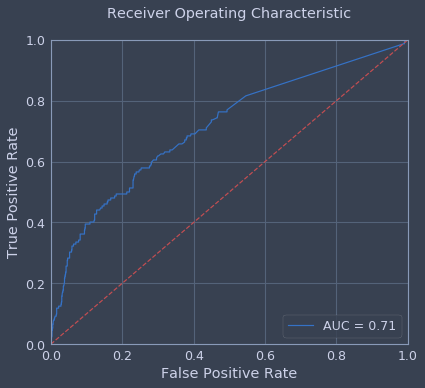

In [93]:
ev.plot_roc_curve(log_model, X_test, y_test)

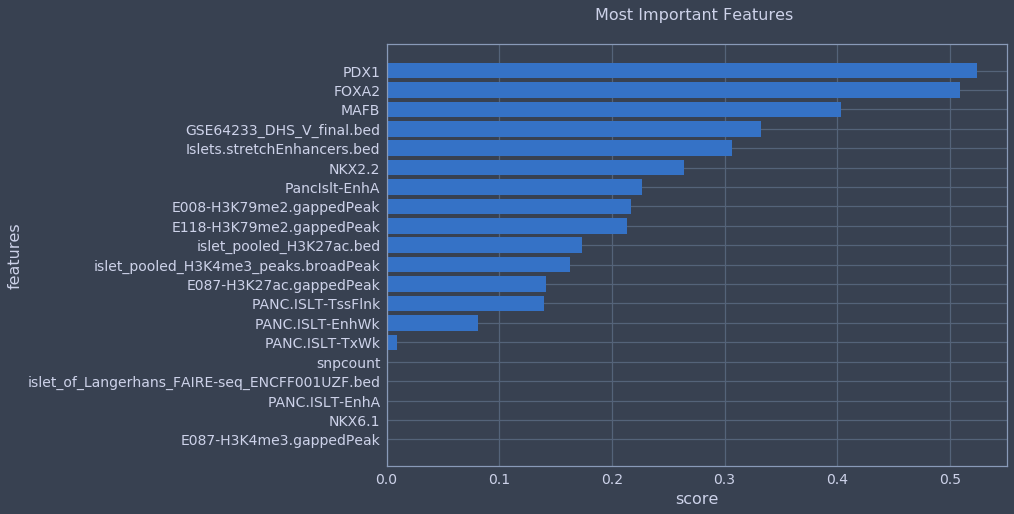

In [94]:
# Plot feature importance
coefs = log_model.coef_
feature_names = X_train.columns
important_features = ev.feat_importance(coefs, feature_names, 20, one_dim=False)[0]

In [95]:
#  ev.recursive_elim(log_model, X_train, y_train, step=10, cv=None)

### Support Vector Machine 

In [96]:
svm_model = SVC(kernel='linear', class_weight='balanced', probability=True, max_iter=5000)
svm_model.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=5000, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [97]:
print("Training Dataset SVM", end=" ")
ev.summarize_performance(svm_model, X_train, y_train, proba=False)

Training Dataset SVM Model Performance:
 Precision: 0.2593856655290102
 Recall: 0.5016501650165016
 Accuracy: 0.7241867043847242


In [98]:
print("Test Dataset SVM", end=" ")
ev.summarize_performance(svm_model, X_test, y_test, threshold=0.5)

Test Dataset SVM Model Performance:
 Precision: 0.0
 Recall: 0.0
 Accuracy: 0.8571428571428571


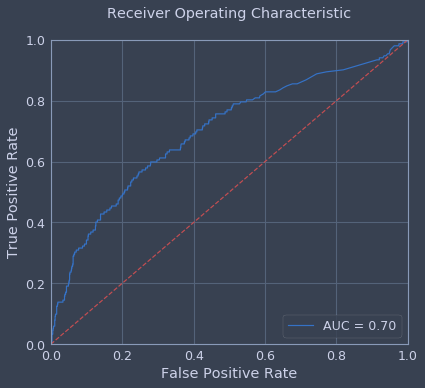

In [99]:
ev.plot_roc_curve(svm_model, X_test, y_test)

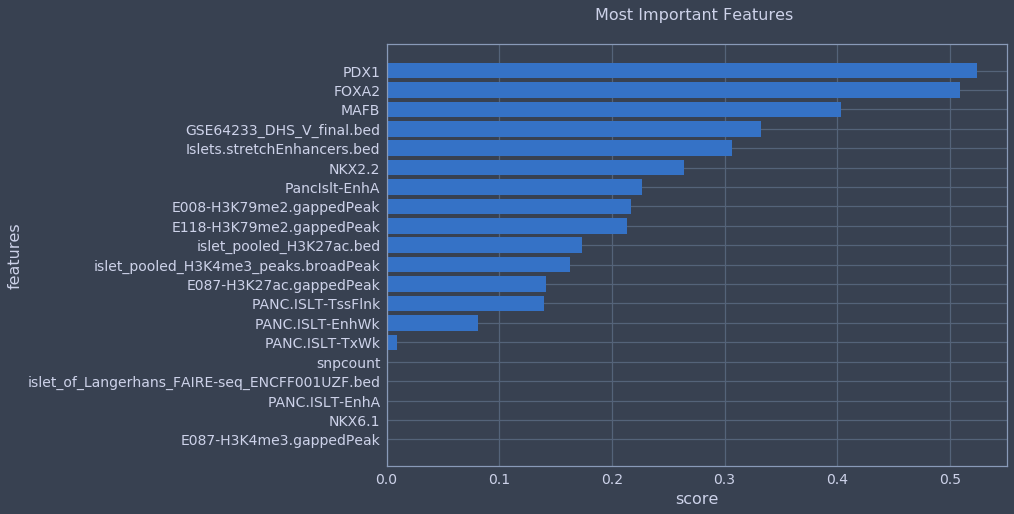

In [100]:
# Plot feature importance
coefs = log_model.coef_
feature_names = X_train.columns
important_features = ev.feat_importance(coefs, feature_names, 20, one_dim=False)

### Random Forest

In [101]:
# if 'snpcount' in X_train.columns:
#     X_train = X_train.drop(['snpcount'], axis=1)
#     X_test = X_test.drop(['snpcount'], axis=1)

In [102]:
# n_jobs = -1 allows training to be done on all available cores
rf_model = RandomForestClassifier(n_jobs=-1, class_weight='balanced', oob_score=True)

# Parameter grid for grid search
rf_params = {'n_estimators': stats.randint.rvs(100, 1000, size=50),
			 'max_depth': stats.randint.rvs(2, len(X_train.columns) - 2, size=15), 
             'min_samples_leaf': stats.uniform(0, 0.4),
             'class_weight':['balanced', 'balanced_subsample']}

scoring = ['recall', 'roc_auc']

cv = StratifiedShuffleSplit(n_splits=10, test_size=0.3)

In [103]:
# Grid search to iteratively search parameter space
rf_grid = RandomizedSearchCV(rf_model, n_iter=100, param_distributions=rf_params,
                             cv=cv, scoring=scoring, refit='roc_auc')
rf_grid.fit(X_train, y_train)
print("The best parameters are %s with a score of %0.2f" % (rf_grid.best_params_, rf_grid.best_score_))

rf_grid_score = rf_grid.score(X_test, y_test)
print ("Grid search's score on new test data was {}".format(rf_grid_score))

The best parameters are {'class_weight': 'balanced_subsample', 'max_depth': 12, 'min_samples_leaf': 0.026657518714634912, 'n_estimators': 917} with a score of 0.65
Grid search's score on new test data was 0.7074785030009234


In [104]:
ev.summarize_performance(rf_grid, X_train, y_train, proba=True)

Model Performance:
 Precision: 0.23872679045092837
 Recall: 0.594059405940594
 Accuracy: 0.6713814238566714


In [105]:
ev.summarize_performance(rf_grid, X_test, y_test, proba=True)

Model Performance:
 Precision: 0.24155844155844156
 Recall: 0.6118421052631579
 Accuracy: 0.6701127819548872


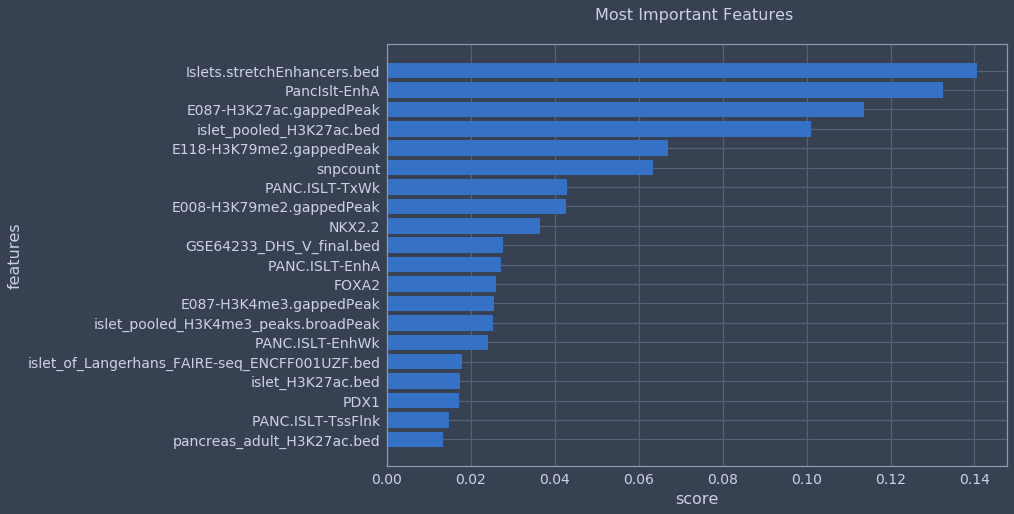

In [106]:
# Plot feature importance
coefs = rf_grid.best_estimator_.feature_importances_
feature_names = X_train.columns
important_features = ev.feat_importance(coefs, feature_names, 20, one_dim=True)

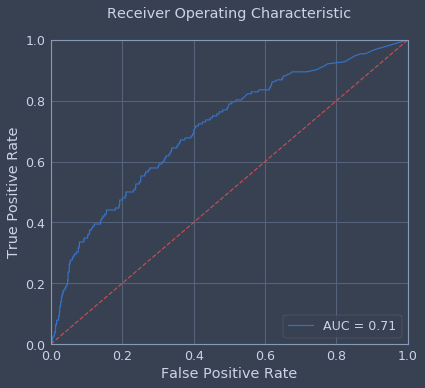

In [107]:
ev.plot_roc_curve(rf_grid, X_test, y_test)

### Gradient Boosted Trees

In [8]:
xgtrain = X_train.values
xgtrain_target = y_train.values
xgtest = X_test.values
xgtest_target = y_test.values

In [9]:
 # parameters to be tries in the grid search
cv_params = {'max_depth': [2, 3,5,7,10, 15, 20], 'min_child_weight': [1,2,3,4,5], 'scale_pos_weight':[2, 5, 7, 9]}   
#other parameters, fixed for the moment 
fix_params = {'learning_rate': 0.1, 'n_estimators': 100, 'objective': 'binary:logistic','silent':1}   
csv = GridSearchCV(xgb.XGBClassifier(**fix_params), cv_params, scoring = 'roc_auc', cv = 5)

In [10]:
# Trying to find best params for max depth and child weight
csv.fit(xgtrain, xgtrain_target)
csv.best_params_

{'max_depth': 2, 'min_child_weight': 5, 'scale_pos_weight': 2}

In [11]:
best_depth = csv.best_params_['max_depth']
best_child_weight = csv.best_params_['min_child_weight']
best_pos_weight = csv.best_params_['scale_pos_weight']

In [12]:
cv_params = {'subsample': [0.8,0.9,1], 'max_delta_step': [0,1,2,4]}
fix_params = {'learning_rate': 0.2, 'n_estimators': 150, 'objective': 'binary:logistic',
              'max_depth': best_depth, 'min_child_weight':best_child_weight, 'scale_pos_weight':best_pos_weight}

In [13]:
csv = GridSearchCV(xgb.XGBClassifier(**fix_params), cv_params, scoring = 'roc_auc', cv = 5) 
csv.fit(xgtrain, xgtrain_target)
csv.best_params_

{'max_delta_step': 0, 'subsample': 0.9}

In [14]:
cv_params = {'learning_rate': [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35]}
fix_params['max_delta_step'] = csv.best_params_['max_delta_step']
fix_params['subsample'] = csv.best_params_['subsample']

In [15]:
csv = GridSearchCV(xgb.XGBClassifier(**fix_params), cv_params, scoring = 'roc_auc', cv = 5) 
csv.fit(xgtrain, xgtrain_target)
csv.cv_results_
csv.best_params_

{'learning_rate': 0.05}

In [16]:
fix_params['learning_rate'] = csv.best_params_['learning_rate']
params_final =  fix_params
params_final['eval_metric'] = 'auc'
params_final['silent'] = 1
print(params_final)

{'learning_rate': 0.05, 'n_estimators': 150, 'objective': 'binary:logistic', 'max_depth': 2, 'min_child_weight': 5, 'scale_pos_weight': 2, 'max_delta_step': 0, 'subsample': 0.9, 'eval_metric': 'auc', 'silent': 1}


In [17]:
xgdmat_train = xgb.DMatrix(X_train, y_train)
xgdmat_test = xgb.DMatrix(X_test, y_test)

xgb_final = xgb.train(params_final, xgdmat_train, num_boost_round = 100)

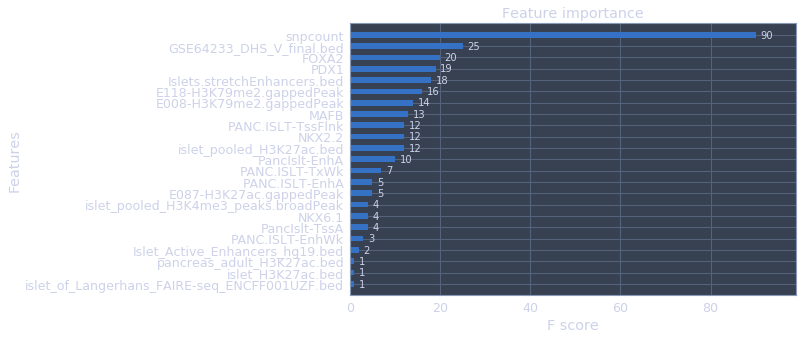

In [28]:
# Plot feature importance
fig, ax = plt.subplots(figsize=(8,5))
xgb.plot_importance(xgb_final, max_num_features=25, height=0.5, ax=ax)
plt.show()

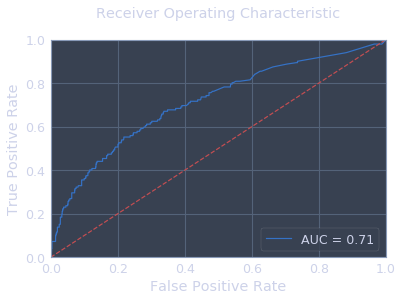

In [19]:
ev.plot_roc_curve(xgb_final, xgdmat_test, y_test, proba=False, model_type='xgboost')

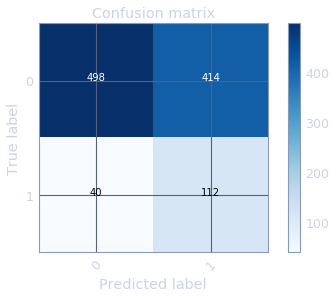

Precision =     0.213
Recall (TPR) =  0.737
Fallout (FPR) = 4.539e-01


In [22]:
y_pred = xgb_final.predict(xgdmat_test)
thresh = 0.19
y_pred [y_pred > thresh] = 1
y_pred [y_pred <= thresh] = 0
cm = confusion_matrix(y_test, y_pred)
ev.plot_confusion_matrix(cm, ['0', '1'], )
pr, tpr, fpr = ev.summarize_cmatrix(cm);

In [123]:
'''
These functions plot roc curves for model performance for each of the specified parameters to plot_roc.
Pass the name of the parameter to name_par and pass values to test to list_par
'''
def get_curves(X_train, y_train, X_val, y_val, pars):
    clf = xgb.XGBClassifier(**pars)
    clf.fit(X_train, y_train)
    y_prob = clf.predict_proba(X_val)[:,clf.classes_[1]]
    fpr, tpr, thresholds_roc = roc_curve(y_val, y_prob)
    prec, rec, thresholds_pr = precision_recall_curve(y_val, y_prob)
    return fpr, tpr, prec, rec


def gen_curves(X_train, y_train, X_val, y_val, pars):
    N_iter = 300
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100000)
    
    mean_prec = 0.0
    mean_rec = np.linspace(0, 1, 100000)
    
    for n in range(N_iter):
        fpr, tpr, prec, rec = get_curves(X_train, y_train, X_val, y_val, pars)
        prec = list(reversed(prec)) #reverse, otherwise the interp doesn not work
        rec = list(reversed(rec))
        mean_tpr  += np.interp(mean_fpr, fpr, tpr)
        mean_prec += np.interp(mean_rec, rec, prec)

    mean_tpr /= N_iter
    mean_prec /= N_iter
    
    return mean_fpr, mean_tpr, mean_prec, mean_rec

In [124]:
def plot_roc(X_train, y_train, X_val, y_val, par, name_par, list_par):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize = (18,7));
    for l in list_par:
        par[name_par] = l
        print(par)
        mean_fpr, mean_tpr, mean_prec, mean_rec = gen_curves(X_train, y_train, X_val, y_val, par)
        ax1.plot(mean_fpr, mean_tpr, label = name_par+" = "+str(l))
        ax2.plot(mean_rec, mean_prec, label = name_par+" = "+str(l))
    ax1.set_xlim([0, 0.0005])
    ax1.set_ylim([0.5, 0.95])
    ax1.axvline(2e-4, color='b', linestyle='dashed', linewidth=2)
    ax1.legend(loc="lower right")
    ax1.set_xlabel('FPR/Fallout')
    ax1.set_ylabel('TPR/Recall')
    ax2.set_xlabel('Recall')
    ax2.set_ylabel('Precision')
    ax1.set_title('ROC')
    ax2.set_title('PR')
    ax2.legend(loc = "lower left")
    ax2.set_xlim([0.5, 1])
    plt.show()

{'learning_rate': 0.3, 'n_estimators': 150, 'objective': 'binary:logistic', 'max_depth': 3, 'min_child_weight': 1, 'scale_pos_weight': 9, 'max_delta_step': 0, 'subsample': 1, 'eval_metric': 'auc', 'silent': 1}
{'learning_rate': 0.3, 'n_estimators': 150, 'objective': 'binary:logistic', 'max_depth': 4, 'min_child_weight': 1, 'scale_pos_weight': 9, 'max_delta_step': 0, 'subsample': 1, 'eval_metric': 'auc', 'silent': 1}
{'learning_rate': 0.3, 'n_estimators': 150, 'objective': 'binary:logistic', 'max_depth': 5, 'min_child_weight': 1, 'scale_pos_weight': 9, 'max_delta_step': 0, 'subsample': 1, 'eval_metric': 'auc', 'silent': 1}
{'learning_rate': 0.3, 'n_estimators': 150, 'objective': 'binary:logistic', 'max_depth': 7, 'min_child_weight': 1, 'scale_pos_weight': 9, 'max_delta_step': 0, 'subsample': 1, 'eval_metric': 'auc', 'silent': 1}
{'learning_rate': 0.3, 'n_estimators': 150, 'objective': 'binary:logistic', 'max_depth': 10, 'min_child_weight': 1, 'scale_pos_weight': 9, 'max_delta_step': 0, 

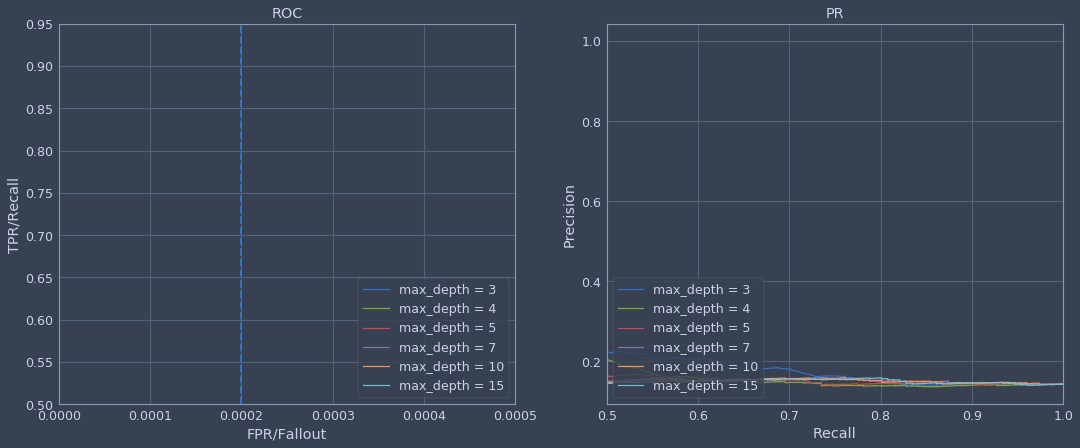

In [67]:
par = params_final
plot_roc(xgtrain, xgtrain_target, xgtest, xgtest_target, par, 'max_depth', [3,4,5,7,10,15])

In [68]:
# Take a look at current params
par

{'learning_rate': 0.3,
 'n_estimators': 150,
 'objective': 'binary:logistic',
 'max_depth': 15,
 'min_child_weight': 1,
 'scale_pos_weight': 9,
 'max_delta_step': 0,
 'subsample': 1,
 'eval_metric': 'auc',
 'silent': 1}

In [69]:
par['max_depth'] = 3
par['learning_rate'] = 0.05
par['n_estimators'] = 200
par['scale_pos_weight'] = 6

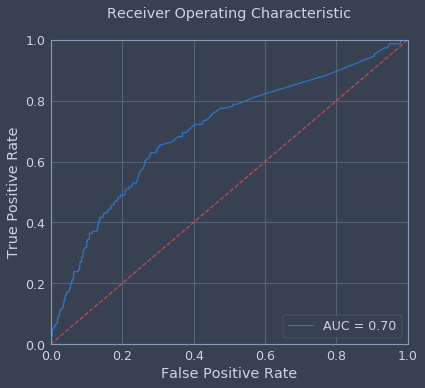

In [70]:
# Based on what we see with the graphs, re run xgboost with the params we think might help
xgb_final = xgb.train(par, xgdmat_train, num_boost_round = 100)
plot_roc_curve(xgb_final, xgdmat_test, y_test, proba=False)